Found 63 images belonging to 1 classes.


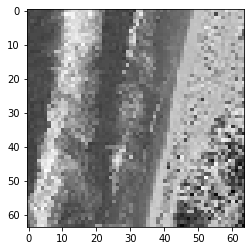

In [191]:
#In this notebook, you'll learn how to implement a Generative Adversarial Network (GAN).
#The goal of a GAN is to create one network - a "Generator" - which seeks to create pictures
#of something (in our case, beaches); the second network is a "Discriminator", which examines
#our generated pictures and tries to determine if they are fake or real.
#The generator network learns over multiple iterations to "fool" the discriminator - 
#hopefully creating some good looking beaches!
#Note GANs are data hungry, so we've got a combination of a few different datasets we're working with,
#including the Mercer database, RESISC45

import keras
import pandas as pd
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import numpy as np

#Note in our data generator, we're only keeping augmentation that wouldn't
#look funny to the human eye - flipping.
dataGenerator = keras.preprocessing.image.ImageDataGenerator()


#Note we're only going to use a training dataset here.
#Our test of accuracy will ultimately be qualitative - how good the beach looks.
#Note we're going to use grayscale here to make the problem more tractable,
#as well as downscale a bit.
train = dataGenerator.flow_from_directory("./beaches", class_mode='categorical', 
                                            batch_size=32, 
                                            color_mode = "grayscale",
                                            target_size=(64,64))                                       

for x,y in train:
    plt.imshow(x[0], interpolation='nearest', cmap="gray")
    plt.show()
    break

In [192]:
#Now, let's build the model that will discrimante - i.e., determine if something is a beach or not.
#Note we have a fairly small dataset, so some of the thigns we're doing here (i.e., dropout) are really
#reflective of best practices in larger-N cases, and not going to help us much here.

def discriminator():
    m = keras.models.Sequential()
    
    #Here's a short convolutional network, using
    #Leaky ReLUs as examples.
    #You could definitely build something better,
    #or use existing nets like ResNet if you wanted.
    m.add(keras.layers.Conv2D(filters=32,
                              kernel_size=(10,10),
                              activation="tanh",
                              input_shape=(64,64,1)))
    m.add(keras.layers.LeakyReLU(alpha=0.1))                    
    m.add(keras.layers.Conv2D(filters=16,
                              kernel_size=(10,10),
                              activation="tanh",
                              input_shape=(64,64,1)))
    m.add(keras.layers.LeakyReLU(alpha=0.1))                    
    m.add(keras.layers.Flatten())

    #Note we have 1 output with sigmoid here - i.e., we'll get one output value from 0 to 1.
    #This will be our "probability it's a beach"
    #With more data, you would probably want more dense layers here, but we'll just do one.
    m.add(keras.layers.Dense(1, activation='sigmoid'))

    m.compile(optimizer=keras.optimizers.SGD(learning_rate=.001),
                                            loss='binary_crossentropy',
                                            metrics=['accuracy'])
    return(m)

model = discriminator()

print(model.summary())


Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 55, 55, 32)        3232      
_________________________________________________________________
leaky_re_lu_590 (LeakyReLU)  (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 46, 46, 16)        51216     
_________________________________________________________________
leaky_re_lu_591 (LeakyReLU)  (None, 46, 46, 16)        0         
_________________________________________________________________
flatten_116 (Flatten)        (None, 33856)             0         
_________________________________________________________________
dense_272 (Dense)            (None, 1)                 33857     
Total params: 88,305
Trainable params: 88,305
Non-trainable params: 0
________________________________________________

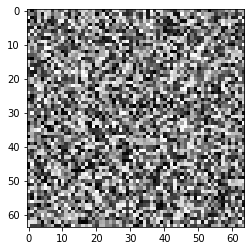

In [193]:
#Now, we need an algorithm that generates fake samples that are
#definitely not beaches.

def generateNotBeaches(batchSize):
    #Here, 256*256*1 is our iomage sizes
    X = np.random.rand(64*64*1*batchSize)
    X = X.reshape((batchSize,64,64,1))
    y = np.zeros((batchSize,1))
    return(X,y)

notBeach = generateNotBeaches(1)

#See, look, not a beach!
plt.imshow(notBeach[0][0], interpolation='nearest', cmap='gray')
plt.show()



In [194]:
#Now we can train our model to discrimate between noise and a beach
#Note I include the model initialization here so the weights get trained from
#a random state each time you run this cell.
model = discriminator()

#Note this will train very quickly - i.e., it's pretty darn easy to tell the difference
#between a beach and random noise!  Note that because we have such a small dataset,
#you may have to run this a few times to hit a good solution set.
#(Also keep in mind we're using image augmentation, so if you're struggling
#to get this to work, adding more augmentations can be very helpful.)
epochs = 10

#Batch size 
batchSize = 32

#Calculate the number of iterations needed for an epoch (i.e., to go through all data):
#Assuming a batch size of 32 here:
iterations = int(np.ceil(train.samples / batchSize))
print("Total Iterations per Epoch: " + str(iterations))
for j in range(epochs):
    i = 1
    for beachX, beachY in train:
        print("================")
        print("Epoch " + str(j+1) + "| Starting iteration " + str(i))
        #First we pass our beach data through
        print("Fitting on real beach data.")
        _, realBeachAcc = model.train_on_batch(beachX, beachY)
        print("Percent of Real Beaches Identified as Real: " + str(realBeachAcc*100))
        #Now we pass our fake data through - we seperate this out on purpose, so we can use a generator seperately later!
        print("Fitting on generated fake data.")
        notBeachX, notBeachY = generateNotBeaches(batchSize)
        _, fakeBeachAcc = model.train_on_batch(notBeachX, notBeachY)
        print("Percent of Fake Beaches Identified as Fake: " + str(fakeBeachAcc*100))
        if i >= iterations:
            break

        i = i + 1

    

Total Iterations per Epoch: 2
Epoch 1| Starting iteration 1
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 96.77419066429138
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 0.0
Epoch 1| Starting iteration 2
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 0.0
Epoch 2| Starting iteration 1
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 0.0
Epoch 2| Starting iteration 2
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 0.0
Epoch 3| Starting iteration 1
Fitting on real beach data.
Percent of Real Beaches Identified as Real: 100.0
Fitting on generated fake data.
Percent of Fake Beaches Identified as Fake: 0.0
Epoch 3| Starting 

In [195]:
#Ok!  Now we're going to create a real generator model.
#Basically, instead of using the random noise like we did above,
#we want a model that can generate images and learn to fool our
#discriminating model.
#The idea here is that we take as input some set of weights - 
#i.e., a random vector, and output our image.  The goal is to 
#find the weights that work best.

def beachGenerator():
    m = keras.models.Sequential()
    
    m.add(keras.layers.Dense(256,input_dim=100))     #We're going to start at a coarse resoltution (60x60), and upscale our way to glory!
                                                        #Note the ,1000 here represents the number of input weights we'll have.
    m.add(keras.layers.LeakyReLU(alpha=0.1))
    m.add(keras.layers.Reshape((16,16,1))) #Put our dimensions first for upsampling
    
    #Here, we're essentially doing a reverse-convolution, as we'll discuss in lecture.
    #The idea is that we're going to create more pixels from a single pixel based on
    #a kernel size and stride, which will give use weights.
    m.add(keras.layers.Conv2DTranspose(32,kernel_size=(2,2),strides=(2,2)))

    m.add(keras.layers.LeakyReLU(alpha=0.1))
    m.add(keras.layers.Conv2DTranspose(1,kernel_size=(2,2),strides=(2,2)))
    m.add(keras.layers.Flatten())
    m.add(keras.layers.Dense(64*64)) 
    m.add(keras.layers.Reshape((64,64,1)))

    m.add(keras.layers.experimental.preprocessing.Rescaling(scale=255, offset=1))

    return(m)

generatorModel = beachGenerator()
generatorModel.summary()

Model: "sequential_273"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_274 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_594 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
reshape_176 (Reshape)        (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_transpose_423 (Conv2D (None, 32, 32, 32)        160       
_________________________________________________________________
leaky_re_lu_595 (LeakyReLU)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_transpose_424 (Conv2D (None, 64, 64, 1)         129       
_________________________________________________________________
flatten_118 (Flatten)        (None, 4096)           

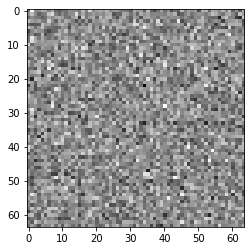

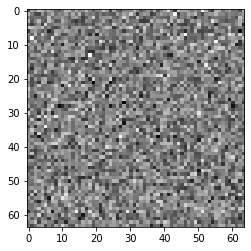

In [196]:
#Now, let's show off how the model can be used to generate some data.
#First, we need to create some random inputs for it to start with - 
#remember, our inputs are a 10000-dimension vector, from our densenet.
#(This can be arbitrarily high or low, depending on your problem)

def generateFakeBeach(genModel, batchSize, init):
    X = genModel.predict(init, batch_size=batchSize)
    y = np.zeros((batchSize, 1))
    return(X,y)

generatorModel = beachGenerator()
rndInput = np.random.randn(100 * batchSize)
rndInput = rndInput.reshape(batchSize, 100)
X,y = generateFakeBeach(generatorModel, 32, init=rndInput)

#Still random data, but this time with random weights and upscaling!
plt.imshow(X[0], interpolation='nearest', cmap="gray")
plt.show()
plt.imshow(X[1], interpolation='nearest', cmap="gray")
plt.show()

Epoch/Iter 432/1 | Discrim Acc: 1.0 |  Generator Loss: 9.296039581298828


<Figure size 432x288 with 0 Axes>

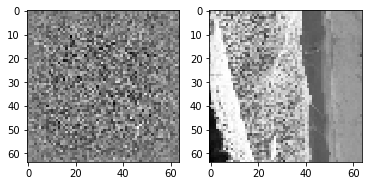

KeyboardInterrupt: 

In [198]:

from IPython.display import clear_output

#Ok - now we need to train our generator.
#The basic idea is that when our discriminator does a good job
#detecting fake samples, we need to update the generator more.
#When it does a bad job, we update it less.

#To do this we're going to combine our two models, similar to what
#we did before with the randomly generated date.

#First, we need to have one large model that we're actually updating
#weights within, that includes both the discriminator and generator.
#We'll use this to update our generator.
def GAN(generator, discriminator):
    #First, we need to set discriminator.trainable to False.
    #This is because we'll be updating the discriminator elsewhere
    #in our loop (and we don't want to double update).
    discriminator.trainable = False

    m = keras.models.Sequential()
    m.add(generator)
    m.add(discriminator)


    m.compile(optimizer=keras.optimizers.SGD(learning_rate=.01),
                                            loss='binary_crossentropy',
                                            metrics=['accuracy'])

    return(m)

discriminatorModel = discriminator()
generatorModel = beachGenerator()
GANModel = GAN(generatorModel, discriminatorModel)
GANModel.summary
epochs = 1000
batchSize = 32
iterations = int(np.ceil(train.samples / batchSize))



for j in range(epochs):
    i = 1
    for beachX, beachY in train:

        rndInput = np.random.rand(100 * batchSize)
        rndInput = rndInput.reshape(batchSize, 100)

        notBeachX, notBeachY = generateFakeBeach(generatorModel, batchSize, init=rndInput)
        #Stack our X and Y together so we only have to backprop once... (the "right" way to do it!)
        X, y = np.vstack((beachX, notBeachX)), np.vstack((beachY, notBeachY))
        discriminatorModel.trainable = True
        modelLoss, modelAcc = discriminatorModel.train_on_batch(notBeachX, notBeachY)
        discriminatorModel.trainable = False
        #And now we update our generator model based on how well the discriminator did
        #If the fake accuracy is 1.0, then we want to change our GAN model a lot.
        #If it's 0.0, then we don't want to change it much at all.

        generatorLoss = GANModel.train_on_batch(rndInput, np.ones((batchSize, 1)))
        if(i%5 == 1):
            clear_output(wait=True)
            print("Epoch/Iter " + str(j) + "/" + str(i) + " | Discrim Acc: " + str(modelAcc) + " |  Generator Loss: " + str(generatorLoss[0]))
            plt.figure()
            f, ax = plt.subplots(1,2)
            ax[0].imshow(notBeachX[0], interpolation='nearest', cmap="gray")
            ax[1].imshow(beachX[0], interpolation='nearest', cmap="gray")
            
            plt.show()


        if i >= iterations:
            break
        i = i + 1       



 
    
